In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
import seaborn as sns
import scipy
import random
import math
from scipy.stats.mstats import winsorize
from tqdm import tqdm
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from IPython.display import Javascript
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from scipy.stats import zscore


import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv("marketing_campaign.csv", sep="\t")
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


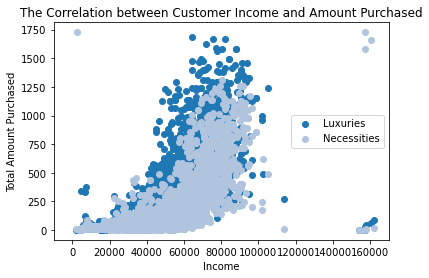

In [3]:
#relationship between income and goods consumption: luxuries and necessities  
age = 2021 - df['Year_Birth'] 
df = df.drop('Year_Birth', axis = 1)
MntLuxury = df['MntWines'] + df['MntSweetProducts'] + df['MntGoldProds']
MntNecessity = df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts']
MntTotal = df['MntWines'] + df['MntSweetProducts'] + df['MntGoldProds'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts']
df['MntLuxury'] = MntLuxury
df['MntNecessity'] = MntNecessity
df['MntTotal'] = MntTotal
all_response = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response'] 
df['Accepted'] = np.array(all_response > 1) * 1
df['Age'] = age
plt.scatter('Income', 'MntLuxury', data = df, marker='o', label = 'Luxuries');
plt.scatter('Income', 'MntNecessity', data = df, marker='o', label = 'Necessities', color = 'lightsteelblue');
plt.title('The Correlation between Customer Income and Amount Purchased')
plt.xlabel('Income')
plt.ylabel('Total Amount Purchased')
plt.legend()
plt.xlim(-10000,170000);

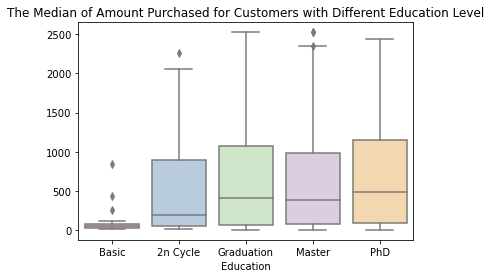

In [4]:
#relationship between education and goods consumption: total 
sns.boxplot(y=MntTotal, x=df['Education'], order=['Basic', '2n Cycle','Graduation','Master','PhD'], palette = 'Pastel1').set(title='The Median of Amount Purchased for Customers with Different Education Level');

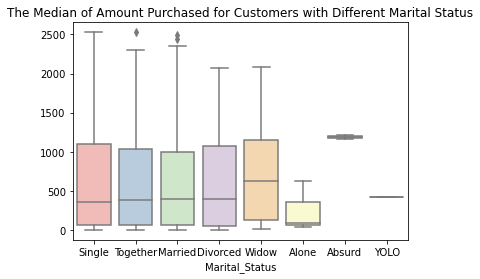

In [5]:
#relationship between marital status and goods consumption: total 
sns.boxplot(y = MntTotal, x=df['Marital_Status'], palette = 'Pastel1').set(title='The Median of Amount Purchased for Customers with Different Marital Status');

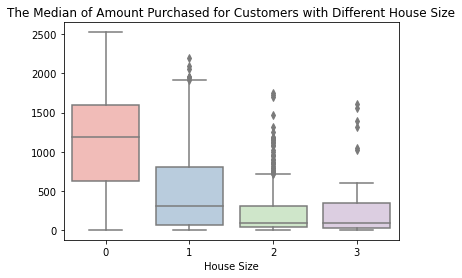

In [6]:
house_size = df['Kidhome'] + df['Teenhome']
df['house_size'] = house_size
sns.boxplot(y = MntTotal, x=house_size, palette = 'Pastel1').set(title='The Median of Amount Purchased for Customers with Different House Size');
plt.xlabel('House Size');

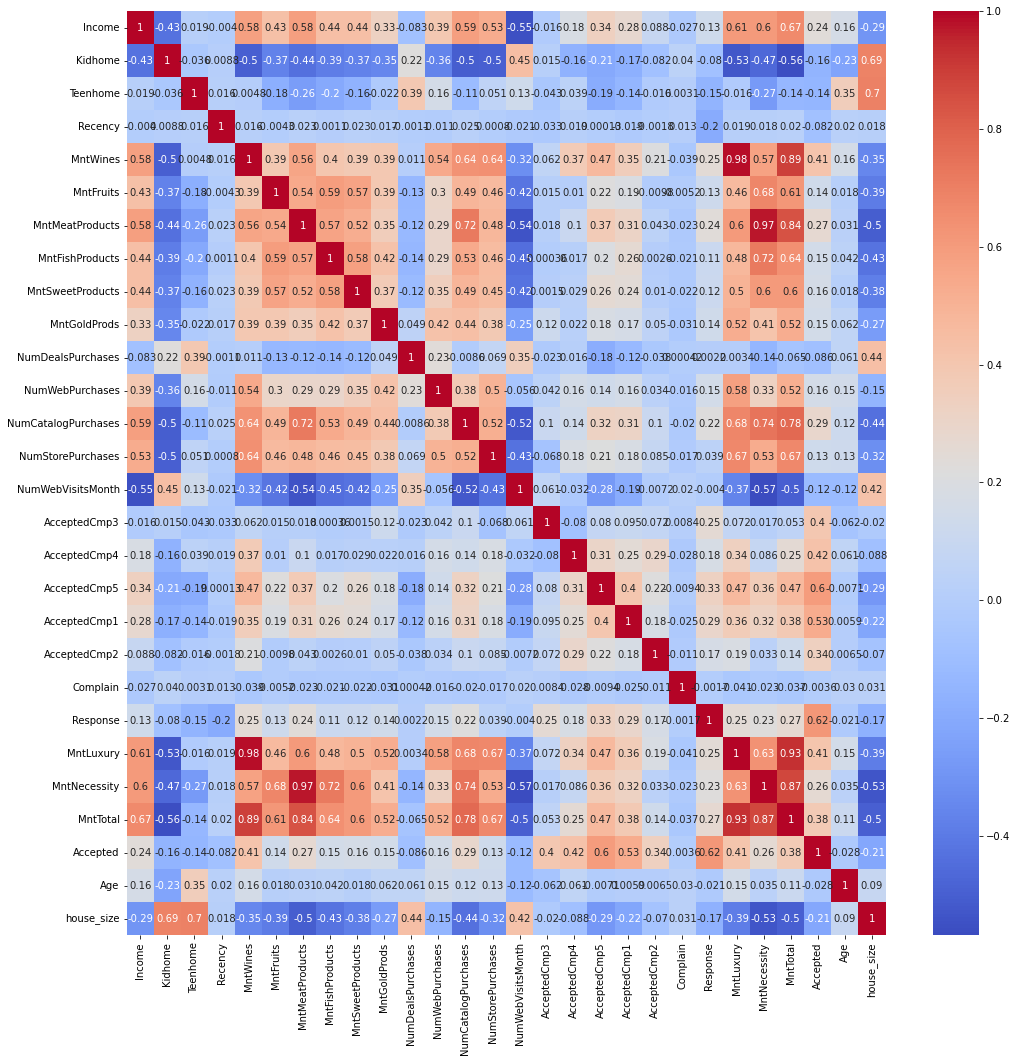

In [7]:
cor = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue']).corr()
plt.figure(figsize = (17, 17))
sns.heatmap(cor, annot = True, cmap = 'coolwarm')
plt.show()

In [8]:
def percentage(array1, total):
  return array1/len(total) * 100 

total_purchase_after_promotion = percentage(sum(df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']), df['ID'])
purchase_after_1st = percentage(sum(df['AcceptedCmp1']), df['ID'])
purchase_after_2nd = percentage(sum(df['AcceptedCmp2']), df['ID'])
purchase_after_3rd = percentage(sum(df['AcceptedCmp3']), df['ID'])
purchase_after_4th = percentage(sum(df['AcceptedCmp4']), df['ID'])
purchase_after_5th = percentage(sum(df['AcceptedCmp5']), df['ID'])
purchase_after_6th = percentage(sum(df['Response']), df['ID'])

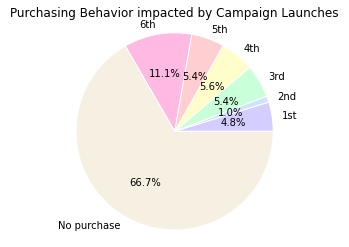

In [9]:
#percentage of people purchased after received promotion 
total_reached = sum(df['Accepted']) / len(df['ID'])

labels = ['1st', '2nd', '3rd', '4th', '5th','6th','No purchase']
sizes = [purchase_after_1st, purchase_after_2nd, purchase_after_3rd, purchase_after_4th, purchase_after_5th, purchase_after_6th, (1-total_reached)*100]
colors = ['#D4CDFF','#CEE3FF','#C9FFD9','#FFFECB','#FFCED0','#FFBAE4','#f5f0e1']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors = colors)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Purchasing Behavior impacted by Campaign Launches');

In [10]:
processed = df[['ID','Age','Income','Recency','MntLuxury','MntNecessity','house_size','Complain']]
marital_status = pd.get_dummies(df['Marital_Status'])
education = pd.get_dummies(df['Education'])
remained = processed['ID']
processed = pd.concat([processed.drop('ID', axis = 1), marital_status, education], axis=1).dropna()
X = processed.dropna().to_numpy()

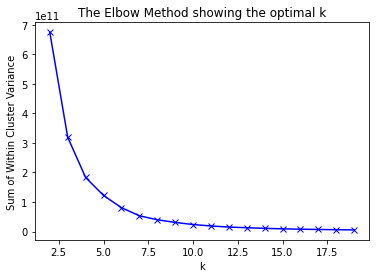

In [11]:
result = []
for i in np.arange(2,20):
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(processed)
  result.append(kmeans.inertia_)

plt.plot(np.arange(2,20), result, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Within Cluster Variance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2216 samples in 0.000s...
[t-SNE] Computed neighbors for 2216 samples in 0.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2216
[t-SNE] Computed conditional probabilities for sample 2000 / 2216
[t-SNE] Computed conditional probabilities for sample 2216 / 2216
[t-SNE] Mean sigma: 106.941080
[t-SNE] Computed conditional probabilities in 0.251s
[t-SNE] Iteration 50: error = 63.5062943, gradient norm = 0.0774711 (50 iterations in 0.489s)
[t-SNE] Iteration 100: error = 54.1526031, gradient norm = 0.0374018 (50 iterations in 0.384s)
[t-SNE] Iteration 150: error = 50.7933693, gradient norm = 0.0311296 (50 iterations in 0.388s)
[t-SNE] Iteration 200: error = 49.2521172, gradient norm = 0.0262370 (50 iterations in 0.380s)
[t-SNE] Iteration 250: error = 48.4327126, gradient norm = 0.0168272 (50 iterations in 0.377s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.432713
[t-SNE] Iteration 300: e

In [13]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(processed)
label = kmeans.labels_

chart = pd.DataFrame(data_embed[:,:2],columns=["x","y"])
chart['ID'] = remained
chart['label'] = label 
chart.head()

,x,y,ID,label
0,21.708076,-28.793625,5524,7
1,-22.547770,-33.671852,2174,2
2,15.734890,-0.221805,4141,0
3,12.466563,23.746973,6182,1
4,22.837496,-29.788616,5324,7


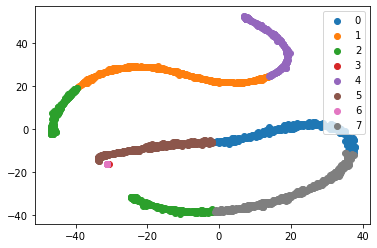

In [30]:
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(chart[label == i]['x'] , chart[label == i]['y'] , label = i)
plt.legend()
plt.show()

In [15]:
def numeric_comparison(max_labels, target_feature):
  label_list = []
  average = []
  median = []
  for i in np.arange(max_labels):
    label_list.append(i)
    id_belonged = chart[chart['label'] == i]['ID'].to_list()
    selected_data = df[df['ID'].isin(id_belonged)].dropna()
    average.append(np.mean(selected_data[target_feature]))
    median.append(np.median(selected_data[target_feature]))
  result = {'Cluster': label_list,
            'Average': average,  
            'Median': median }
  result = pd.DataFrame(result)
  return result.sort_values('Median', ascending = False)

In [16]:
def binary_comparison(max_labels, target_feature):
  label_list = []
  average = []
  for i in np.arange(max_labels):
    label_list.append(i)
    id_belonged = chart[chart['label'] == i]['ID'].to_list()
    selected_data = df[df['ID'].isin(id_belonged)].dropna()
    average.append(np.mean(selected_data[target_feature]))
  result = {'Cluster': label_list,
            'Average': average}
  result = pd.DataFrame(result)
  return result.sort_values('Average', ascending = False)

In [17]:
def categorical_comparison(max_labels, target_feature):
  label_list = []
  for i in np.arange(max_labels):
    label_list.append(i)
    id_belonged = chart[chart['label'] == i]['ID'].to_list()
    selected_data = df[df['ID'].isin(id_belonged)].dropna()
    arranged = selected_data.groupby(target_feature).agg(len)[['ID']]
    labels = arranged.index.to_list()
    sizes = arranged['ID'].tolist()
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors = colors)
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title('Composition of Feature ' + target_feature + ' of Cluster ' + str(i));  

In [18]:
def categorical_comparison_purchases(max_labels):
  label_list = []
  for i in np.arange(max_labels):
    label_list.append(i)
    id_belonged = chart[chart['label'] == i]['ID'].to_list()
    selected_data = df[df['ID'].isin(id_belonged)].dropna()
    sum_results = selected_data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum()
    labels = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
    sizes = np.array(sum_results) / sum(np.array(sum_results))
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors = colors)
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title('Composition of purchase places of Cluster ' + str(i));  

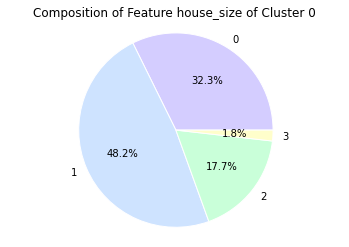

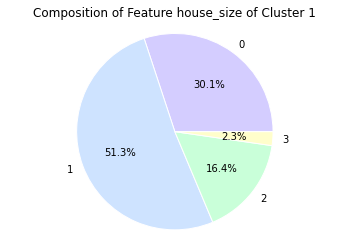

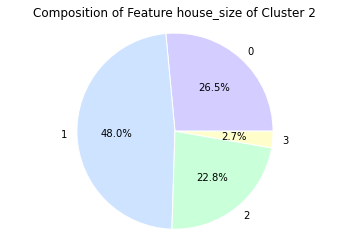

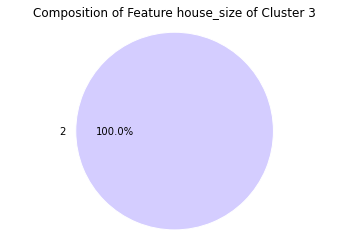

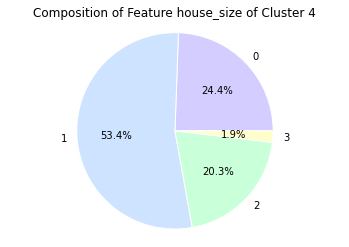

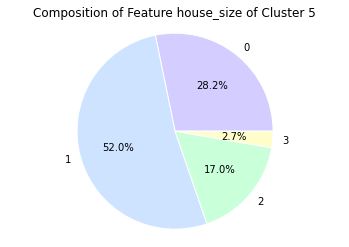

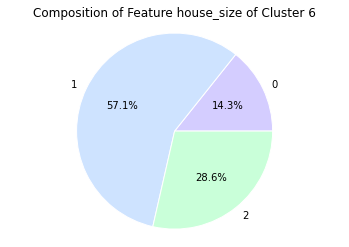

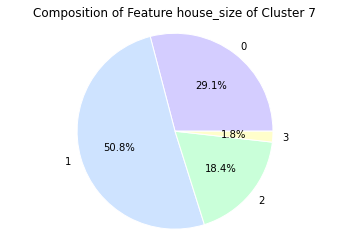

In [19]:
categorical_comparison(8, 'house_size')

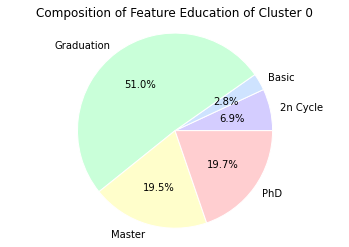

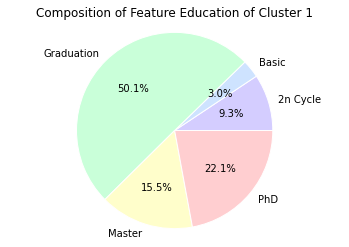

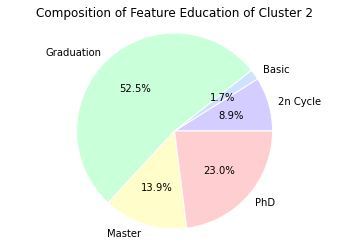

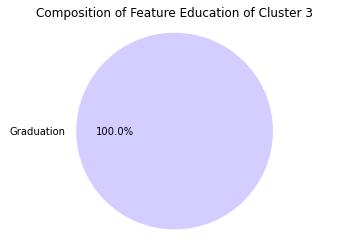

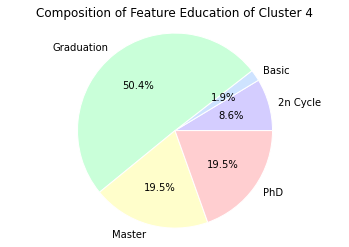

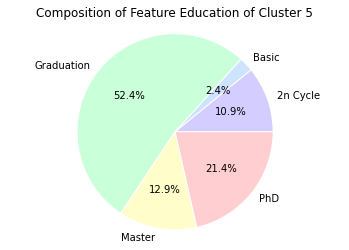

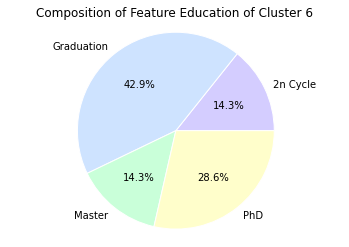

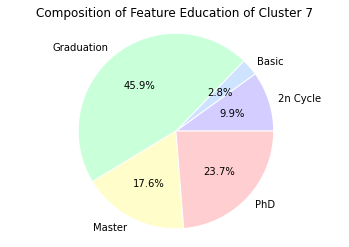

In [20]:
categorical_comparison(8, 'Education')

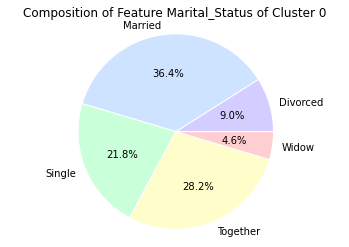

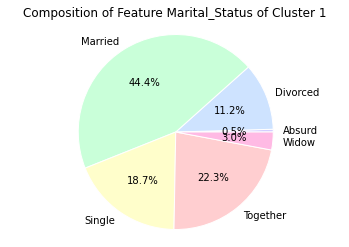

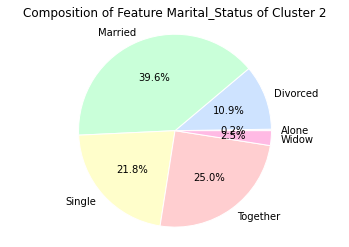

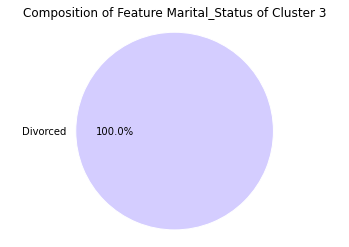

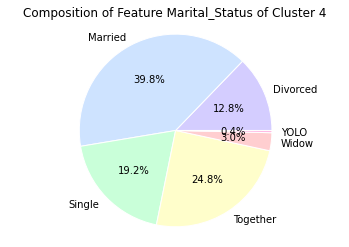

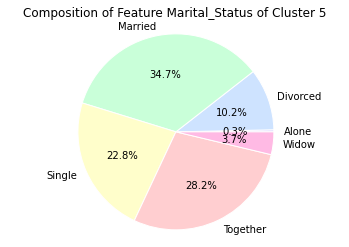

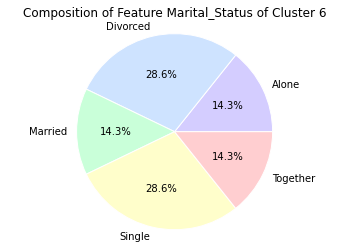

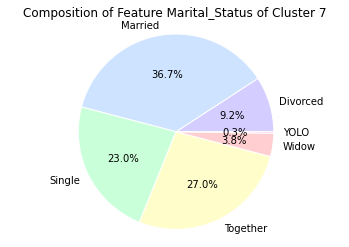

In [21]:
categorical_comparison(8, 'Marital_Status')

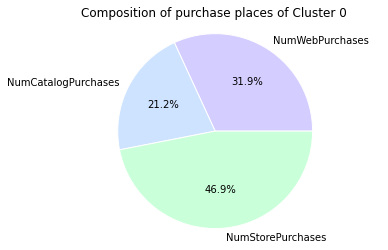

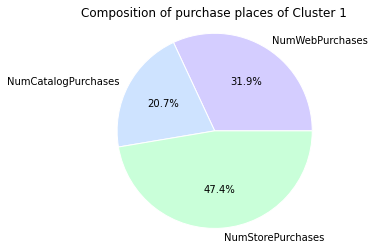

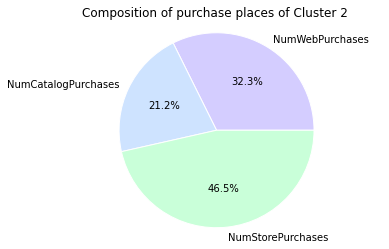

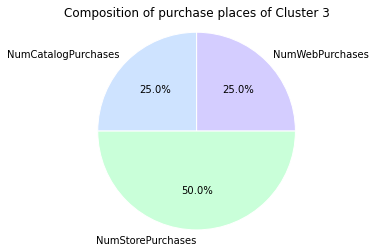

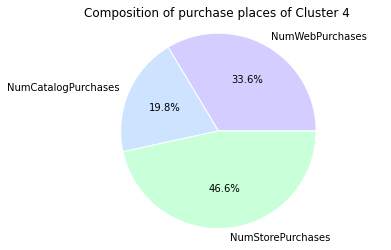

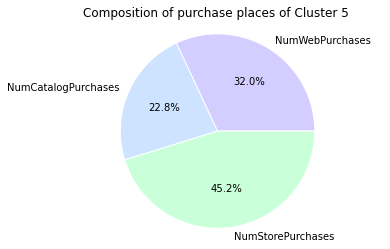

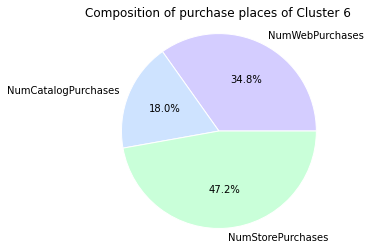

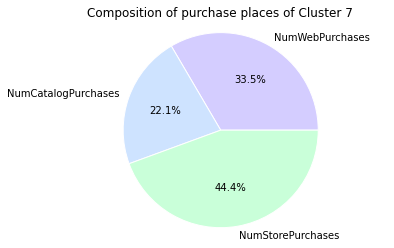

In [22]:
categorical_comparison_purchases(8)

In [23]:
binary_comparison(8, 'Complain')

,Cluster,Average
1,1,0.013667
5,5,0.013605
7,7,0.012755
0,0,0.007692
2,2,0.004950
4,4,0.003759
3,3,0.000000
6,6,0.000000


In [24]:
numeric_comparison(8, 'Income')

,Cluster,Average,Median
2,2,53179.076733,54327.0
7,7,52360.451531,51546.0
4,4,50942.221805,50727.0
0,0,52117.635897,50699.5
1,1,51384.829157,50300.0
5,5,51746.993197,50124.5
6,6,54061.714286,50002.0
3,3,45146.000000,45146.0


In [25]:
numeric_comparison(8, 'Recency')

,Cluster,Average,Median
6,6,54.714286,63.0
1,1,48.640091,51.0
7,7,50.951531,51.0
2,2,49.099010,50.5
0,0,49.335897,50.0
5,5,47.969388,47.0
4,4,47.240602,46.0
3,3,28.000000,28.0


In [26]:
numeric_comparison(8, 'MntLuxury')

,Cluster,Average,Median
6,6,514.285714,541.0
2,2,411.131188,304.0
7,7,384.734694,263.5
4,4,372.101504,251.5
0,0,375.346154,238.0
1,1,359.697039,226.0
5,5,345.581633,196.0
3,3,48.000000,48.0


In [27]:
numeric_comparison(8, 'MntNecessity')

,Cluster,Average,Median
2,2,231.398515,104.5
0,0,234.446154,100.5
6,6,233.857143,97.0
7,7,249.535714,90.5
5,5,227.248299,86.0
4,4,216.394737,82.5
1,1,226.977221,80.0
3,3,5.000000,5.0


In [28]:
numeric_comparison(8, 'Age')

,Cluster,Average,Median
3,3,58.000000,58.0
6,6,53.571429,55.0
4,4,52.458647,52.0
2,2,52.955446,51.5
0,0,52.202564,51.0
1,1,52.054670,51.0
5,5,52.357143,51.0
7,7,51.288265,50.0


In [29]:
binary_comparison(8, 'Accepted')

,Cluster,Average
6,6,0.142857
2,2,0.113861
7,7,0.109694
0,0,0.107692
5,5,0.105442
1,1,0.102506
4,4,0.101504
3,3,0.000000
